# Group Project Report: Pulsar Star Classification
**Authors:** Sneh Agarwal, Janahan Dhushenthen, Blake Kezar, and Max Mai <br>
**Date:** December 8, 2021

## 1. Introduction

### Background
Pulsars are rapidly rotating, highly magnetized neutron stars that produce radio emissions detectable on earth. They have attracted scientific interest as being probes of space time, interstellar medium, and states of matter.

Each pulsar produces a unique emission with every rotation. A potential signal detection, called a candidate, is averaged over several rotations of the pulsar. In real practice, nearly all detections are caused by radio frequency interference (RFI) and noise, making it difficult to filter legitimate signals. Each candidate could potentially describe a real pulsar in absence of additional information.

Nowadays, machine learning tools are being used extensively to automatically label pulsar candidates, facilitating rapid analysis. Classification systems are being used widely, treating data sets as binary classification problems. In these data sets, legitimate pulsar examples are the minority positive class and spurious examples are the majority negative class.

### The Question
We would like to perform K-nearest neighbours classification on pulsar star candidates. Based on our research, we identified two key measurements related to pulsar stars:
1. The integrated profile: This is formed from the pulsar signal with respect to its rotational period. Unlike a single pulse, which is highly variable, the integrated profile is consistent and stable in time. Each profile shape is unique and acts like a fingerprint for the pulsar. 
2. The DM-SNR curve: This stands for "dispersion measure signal-to-noise ratio". The DM-SNR curve respresents the dispersion of the pulsar signal and accounts for noise from other electromagnetic waves. 

We decided to use the mean values of the integrated profile and DM-SNR curve as our predictors, because it gives us a measure of their central tendency, which we believe will be distinguishable for each class. 

Therefore, the predictive question that we will try to answer is: **Given the mean of integrated profile and mean of the DM-SNR curve, can we determine if a particular candidate is a pulsar or non-pulsar star?**

### The Dataset
We will be using the [HTRU2 Data Set](https://archive.ics.uci.edu/ml/datasets/HTRU2) to answer our question. This dataset contains a sample of pulsar candidates collected during the High Time Resolution Universe Survey.

The dataset contains a total of 17 898 observations, including 1 639 legitimate pulsar observations and 16 259 spurious observations. The dataset contains 8 continuous variables and a class variable, which are listed below:
1. Mean of integrated profile
2. Standard deviation of integrated profile
3. Excess kurtosis of integrated profile
4. Skewness of integrated profile
5. Mean of the DM-SNR curve
6. Standard deviation of the DM-SNR curve
7. Excess kurtosis of the DM-SNR curve
8. Skewness of the DM-SNR curve
9. Class 


## 2. Methods & Results

### Getting Started

First, we will perform some preliminary exploration of the pulsar data. We start off by importing the required libraries and setting a random seed for the analysis.

In [50]:
# Import libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(knitr)

In [51]:
# Set random seed for analysis
set.seed(3456)

### Reading in the Dataset
Next, we download and store a zip file from the UCI Machine Learning Repository, which contains the HTRU2 dataset. We then read in the CSV file within it that contains the pulsar data. When reading in this file, we assign the column names described in the attribute information, and convert the class variable to a factor (since we will be performing binary classification). We also select the subset of columns that we need, which are the mean of the integrated profile, mean of the DM-SNR curve, and the class.

In [52]:
# Download zip file from online archive 
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
temp <- tempfile()
download.file(url, temp)

# Read in CSV file containing pulsar data
pulsar_data <- read_csv(unz(temp, "HTRU_2.csv"), col_names = c("Profile_mean", "Profile_stdev", "Profile_skewness", "Profile_kurtosis", "DM_mean", "DM_stdev", "DM_skewness", "DM_kurtosis", "class")) %>%
               mutate(class = as_factor(class)) %>%
               select(Profile_mean, DM_mean, class)
unlink(temp)

Parsed with column specification:
cols(
  Profile_mean = col_double(),
  Profile_stdev = col_double(),
  Profile_skewness = col_double(),
  Profile_kurtosis = col_double(),
  DM_mean = col_double(),
  DM_stdev = col_double(),
  DM_skewness = col_double(),
  DM_kurtosis = col_double(),
  class = col_double()
)



### Summarizing the Data
Here, we split the dataset into 75% training data and 25% testing data, using stratified sampling with respect to the outcome variable class. There is a tradeoff between using more training data for improved accuracy of the model and more testing data for improved accuracy of the evaluation. The 75/25 split that we use is supported by empirical research, where any split that uses 70-80% training data and 20-30% testing data usually results in the most accurate model.

In [53]:
# Split pulsar dataset into training and testing data
pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = class)
pulsar_test <- testing(pulsar_split)
pulsar_train <- training(pulsar_split)

We now summarize the training data into tables. For our first table, we find the number of observations in each class. The data set should have approximately the same proportion of each class, so that the classification algorithm isn't more likely to choose one class over the other. Based on Table 1 below, we can see that there are a lot more non-pulsar observations than pulsar observations. This means that we will have to perform upsampling on the training data later, so that each class gets equal representation and the model is not skewed.

In [64]:
# Report the number of observations in each class
n_by_class <- pulsar_train %>% 
              group_by(class) %>%
              summarize(n = n())
n_by_class

`summarise()` ungrouping output (override with `.groups` argument)



class,n
<fct>,<int>
0,12188
1,1236


**Table 1: Number of observations in each class**

For our second table, we calculate the means of the predictor variables. Based on Table 2 below, we can see the mean of the integrated profile is 111.1 and the mean of the DM-SNR curve is 12.7. This shows that we need to center the data, so that the classification algorithm will get equal contributions from each variable. 

In [65]:
# Report the means of the predictor variables
mean_by_predictor <- pulsar_train %>% 
                     summarize(across(Profile_mean:DM_mean, mean)) %>%
                     pivot_longer(cols = Profile_mean:DM_mean, names_to = "predictor", values_to = "mean")
mean_by_predictor

predictor,mean
<chr>,<dbl>
Profile_mean,111.17591
DM_mean,12.76068


**Table 2: Means of the predictor variables**

For our last table, we identify the number of rows that have missing data. This will help us identify the number of valid observations that we can use for our analysis. Based on Table 3 below, we have no missing data, so we can use all of the observations in training.

In [26]:
# Report how many rows have missing data
num_NAs <- pulsar_train %>% 
           filter(is.na(pulsar_train)) %>% 
           summarize(NAs = n())
num_NAs

NAs
<int>
0


**Table 3: Number of rows with missing data**

### Visualizing the Data
Next, we create a visualization that compares the distributions of each of the predictor variables. We accomplish this by creating density plots for each predictor, separating the curves by class. For each predictor, we can see that the classes form two distinct distributions, which means that they are distinguishable and a meaningful classification is possible. We also see that the variance is different between the predictors. This shows that we need to scale the data, so that the classification algorithm will get equal contributions from each variable.

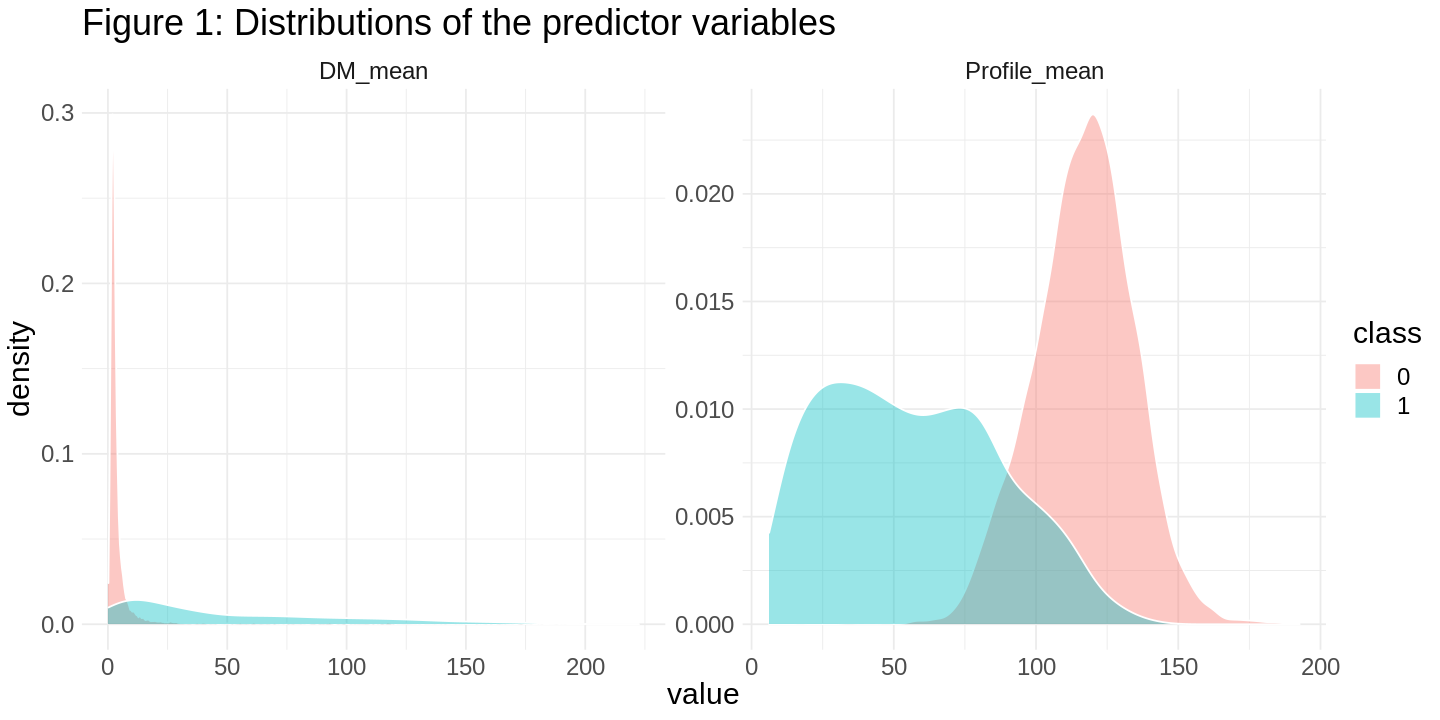

In [116]:
# Set the plot width and height
options(repr.plot.width = 12, repr.plot.height = 6) 

# Create density plot, which visualizes the distribution of each predictor variable
pulsar_train %>%
    pivot_longer(cols = -class, names_to = 'category', values_to = 'value')  %>% 
    ggplot(aes(value, fill = class)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(~ category, scales = 'free') +
        theme_minimal() +
        theme(text = element_text(size = 18)) +
        ggtitle("Figure 1: Distributions of the predictor variables")

### Parameter Value Selection
The exploratory analysis is now complete and we move on to the predictive analysis. First, we will use cross-validation on our training set to select the optimal value for the number of neighbours K. We will start by creating the recipe for our model, where we standardize the predictors through scaling and centering, and then perform upsampling to balance the class variable. Due to some issues with JupyterLab, we are using the deprecated version of the step_upsample function. This requires us to prep and bake the recipe with the training data and pass it into a dummy recipe for cross-validation to successfully work.

In [76]:
baked_training <- recipe(class ~ Profile_mean + DM_mean, data = pulsar_train) %>%
                  step_scale(all_predictors()) %>%
                  step_center(all_predictors()) %>%
                  step_upsample(class, over_ratio = 1, skip = FALSE) %>%
                  prep() %>%
                  bake(pulsar_train)

dummy_recipe <- recipe(class ~ Profile_mean + DM_mean, data = baked_training)

Next, we will set the model specification, such that we are performing k-nearest neighbours classification. The rectangular weight function means that k-nearest neighbours will use straight-line distance and we tune the neighbours to find the optimal value.

In [78]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

Here, we create a cross-validation dataset from the training data. We perform stratified sampling from the class and use 5-folds. Typically, 5 or 10 folds are used for cross-validation, depending on the computing power. We chose 5, due to the size of the data and the speed of our algorithm and computers. We then pass the recipe, model specification and cross-validation data into a workflow. The accuracy is evaluated for 10 different values of K and the metrics are collected. 

In [79]:
pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = class)

knn_results <- workflow() %>%
               add_recipe(dummy_recipe) %>%
               add_model(knn_spec) %>%
               tune_grid(resamples = pulsar_vfold, grid = 10) %>%
               collect_metrics()

We can then pull the accuracies from the metrics and plot the accuracy of each of the values of K. Based on the plot below, we choose K = 3 to be optimal, which resulted in an estimated accuracy of approximately 97%. After this point, the estimated accuracy only increases marginally.

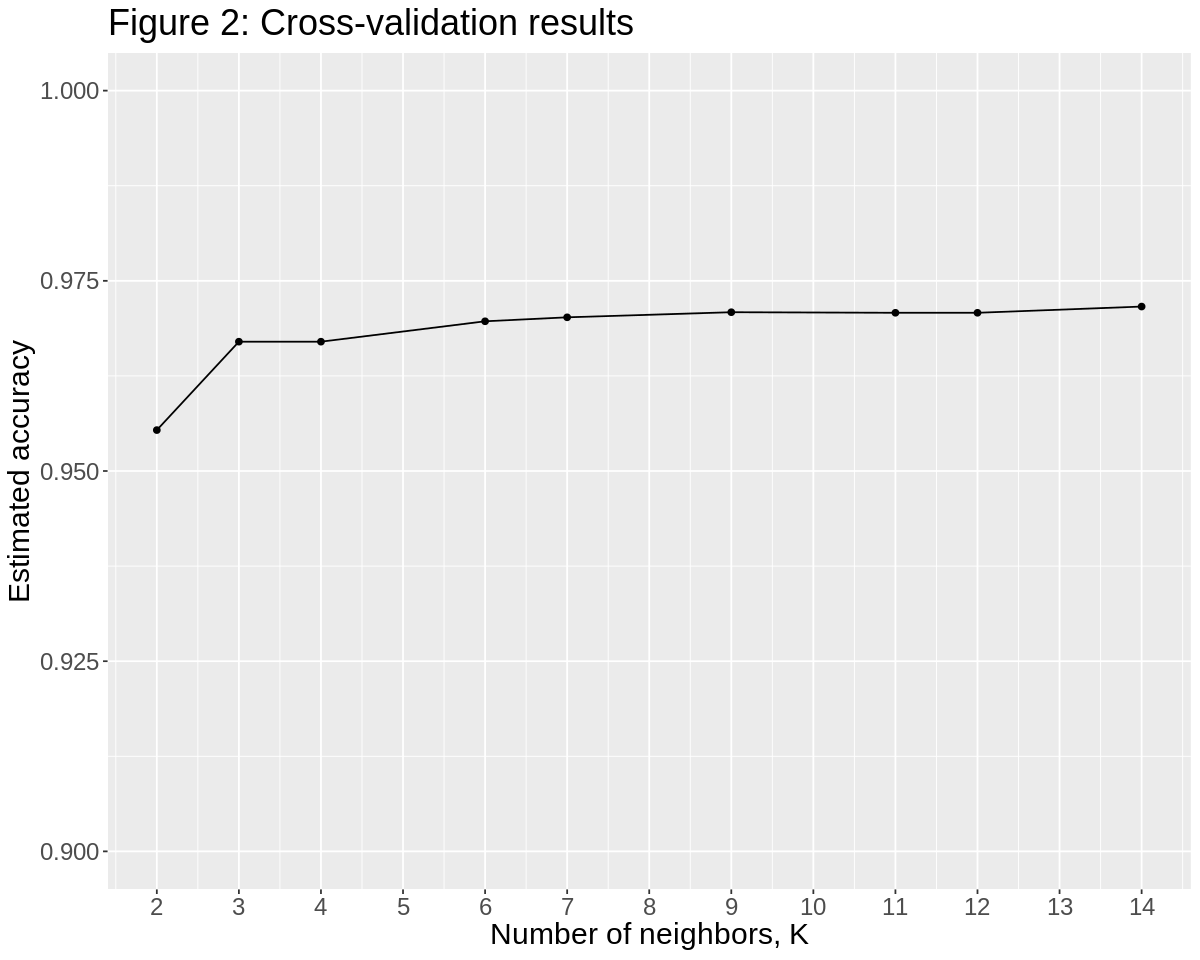

In [90]:
options(repr.plot.width = 10, repr.plot.height = 8) 

accuracies <- knn_results %>% 
              filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  ggtitle("Figure 2: Cross-validation results") + 
                  labs(x = "Number of neighbors, K", y = "Estimated accuracy") +
                  theme(text = element_text(size = 18)) + 
                  scale_x_continuous(breaks = seq(0, 14, by = 1)) +
                  scale_y_continuous(limits = c(0.90, 1.0))
cross_val_plot

Now, we redo the model specification (and the resulting workflow) using K = 3. This is then used to make predictions on the testing dataset.

In [92]:
pulsar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
               set_engine("kknn") %>%
               set_mode("classification")

pulsar_fit <- workflow() %>%
              add_recipe(dummy_recipe) %>%
              add_model(pulsar_spec) %>%
              fit(data = pulsar_train)

pulsar_predictions <- predict(pulsar_fit, pulsar_test) %>%
                      bind_cols(pulsar_test)

We can now get the metrics about the predictions. In Table 4 below, we can see that the classifier was 97% accurate on the testing data.

In [94]:
pulsar_metrics <- pulsar_predictions %>%
                  metrics(truth = class, estimate = .pred_class)             
pulsar_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9696021
kap,binary,0.8031173


**Table 4: Prediction metrics of the classifier**

We can also look at the confusion matrix in Table 5 below. It shows that in the testing data, 4029/4071 observations were correctly classified non-pulsar and 309/403 observations were correctly classified pulsar.

In [95]:
pulsar_conf_mat <- pulsar_predictions %>% 
                   conf_mat(truth = class, estimate = .pred_class)
pulsar_conf_mat

          Truth
Prediction    0    1
         0 4029   94
         1   42  309

**Table 5: Confusion matrix of the classifier**

Finally, we can display the results of the classifier using scatterplots. First, we create a plot for the true pulsar star classification, using the actual classes from the data set. We have the mean of the DM-SNR curve on the y-axis and the mean of the integrated profile on the x-axis, but this is arbitrary. The classes are also separated by colour.

In [118]:
pulsar_plot <- pulsar_predictions %>%
               ggplot(aes(x = Profile_mean, y = DM_mean, colour = class)) + 
                   geom_point(alpha = 0.4) + 
                   xlab("Mean of the integrated profile") +
                   ylab("Mean of the DM-SNR curve") +
                   labs(colour = "Actual class") +
                   ggtitle("Actual pulsar star classification") + 
                   theme(text = element_text(size = 18))

Similarly, we create a plot for the predicted pulsar star classification, using the predicted classes from our K-nearest neighbours model.

In [ ]:
pulsar_pred_plot <- pulsar_predictions %>%
                    ggplot(aes(x = Profile_mean, y = DM_mean, colour = .pred_class)) + 
                       geom_point(alpha = 0.4) + 
                       xlab("Mean of the integrated profile") +
                       ylab("Mean of the DM-SNR curve") +
                       labs(colour = "Predicted class") +
                       ggtitle("Predicted pulsar star classification") + 
                       theme(text = element_text(size = 18))

Finally, we place the two plots side-by-side in Figure 3 below.  The non-pulsars are coloured red and the pulsars are coloured blue. As we can see, both plots are very similar, with two distinct groupings in the data that separate the classes.

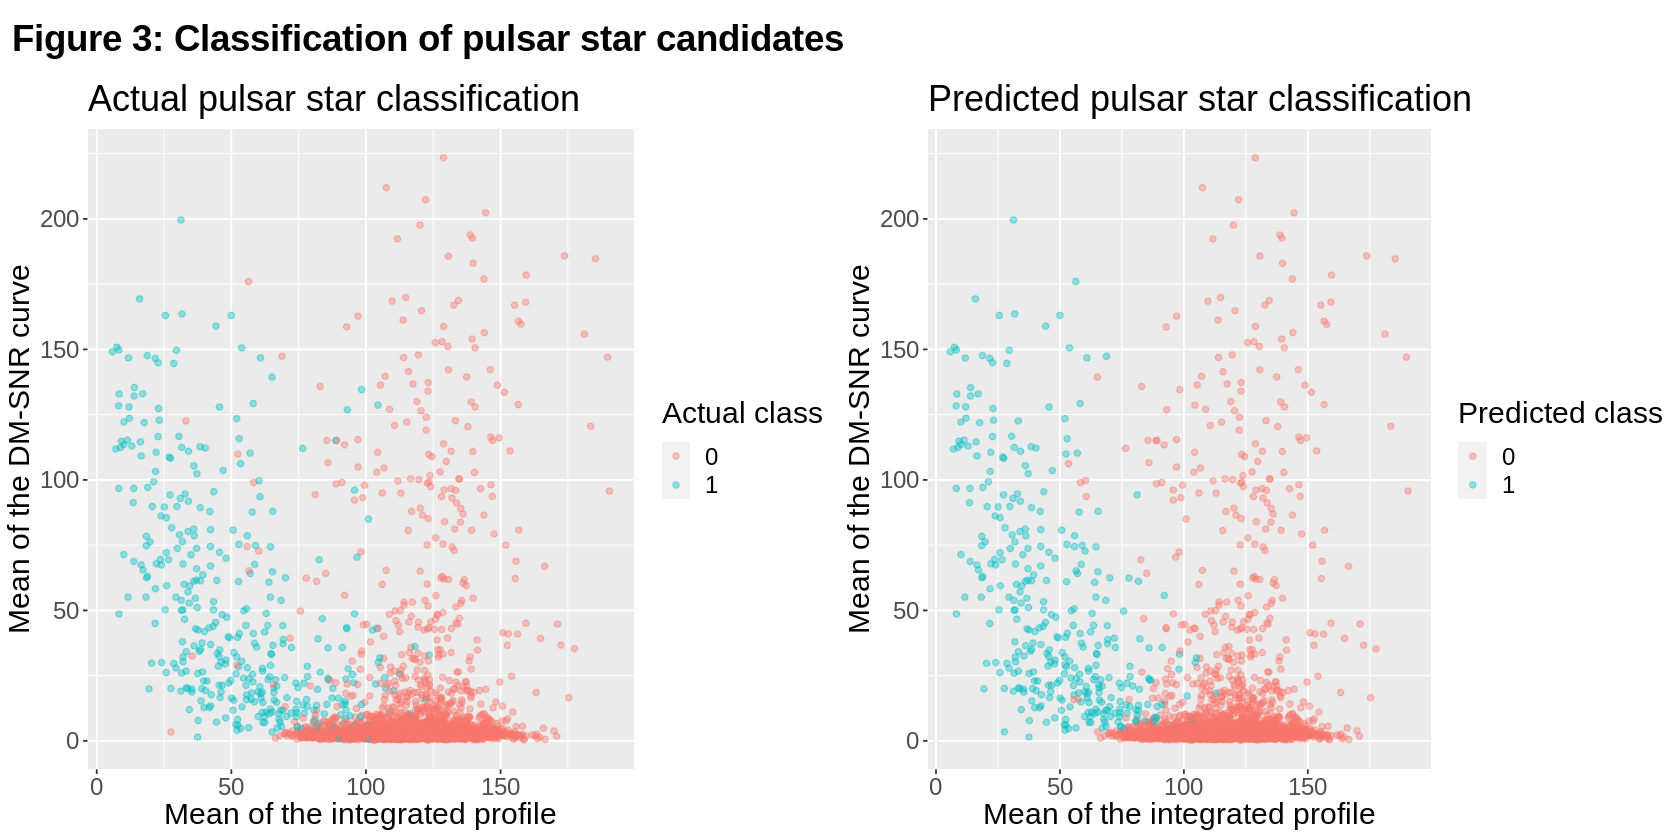

In [119]:
options(repr.plot.width = 14, repr.plot.height = 7) 

plot_row <- plot_grid(pulsar_plot, pulsar_pred_plot)

title <- ggdraw() + 
          draw_label("Figure 3: Classification of pulsar star candidates", fontface = 'bold', x = 0, hjust = 0, size = 22) +
          theme(plot.margin = margin(0, 0, 0, 7))

plot_grid(title, plot_row, ncol = 1, rel_heights = c(0.1, 1))

## 3. Discussion 

### Summary of Findings
Using the HTRU2 data set, we were able to construct a model that performs K-nearest neighbours classification on pulsar star candidates. When constructing the model, we used a 75/25 training-testing split of the data. We also performed 5-fold cross-validation to find the optimal number of neighbours, which we determined to be K = 3. Given the mean of the integrated profile and mean of the DM-SNR curve, the model is able to classify candidates as pulsar or non-pulsar with 97% accuracy. We can see that the model is better at correctly classifying non-pulsars than pulsars, as 4029/4071 observations were correctly classified non-pulsars and 309/403 observations were correctly classified pulsars. When visualized, the predicted and actual classifications of the candidates match up closely, as both form two distinct groups in the data.

### Findings vs Expectations
Utilizing the model we created, we are able to successfully classify candidates as pulsar or non-pulsar stars with a very high accuracy. Although we did expect the mean of the integrated profile and mean of the DM-SNR curve to be good predictors, we did not expect the accuracy to be this high. One possible reason for this high accuracy might be data leakage. This could be caused by upsampling before the cross-validation step, since the duplicated observations could appear in both the training and testing splits, inflating the evaluated accuracy. In addition, the true accuracy might not be reflected in the testing set, since it has many more non-pulsar classes than pulsar classes. We can even see that only 309/403 pulsars were correctly classified, which is only about 77% accurate.

### Potential Impacts
With the pulsar stars we find, scientists can study extreme states of matter, search for planets beyond Earth's solar system, and measure cosmic distances. Pulsars could also help scientists find gravitational waves, which could point the way to energetic cosmic events like collisions between supermassive black holes (Cofield, 2016). Similarly, pulsars are valuable in identifying and confirming the presence of gravitational radiation, attuning to Einstein's theory of general relativity. Therefore, knowing and understanding where a pulsar star exists is crucial to the greater understanding of our universe.

### Potential Future Questions
This can lead to a number of questions, such as:
* What things are inside a pulsar star?
* How big and wide is a pulsar star?
* How do magnetic fields and extreme gravity affect the radiation?

## 4. References
[1] R. J. Lyon et al., 'Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach', Monthly Notices of the Royal Astronomical Society 459 (1), 1104-1123, DOI: 10.1093/mnras/stw656 <br>
[2] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. <br>
[3] Gholamy, A., Kreinovich, V., & Kosheleva, O. (2018). (tech.). Why 70/30 or 80/20 Relation Between Training and Testing Sets: A Pedagogical Explanation. El Paso, Texas: DigitalCommons. <br>
[4] Cofield, C. (2016, April 22). What are pulsars? Space.com. Retrieved December 5, 2021, from https://www.space.com/32661-pulsars.html. <br>